# Configuração de ambiente

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c isic-2024-challenge
!unzip isic-2024-challenge.zip -d Image

In [1]:
!mkdir Image_Segmentation

In [ ]:
#%pip install crewai crewai-tools poetry vllm
!curl -fsSL https://ollama.com/install.sh | sh
!pip install pymupdf langchain-community langchain-core langgraph faiss-cpu
!pip install langchain --upgrade

In [18]:
!nohup ollama serve > ollama.log &
!nohup ollama run llava:13b &

nohup: redirecting stderr to stdout
nohup: appending output to 'nohup.out'


# Criação da RAG leve com base no PDF

In [ ]:
import pymupdf  # PyMuPDF
import os
import zipfile

# Caminho do arquivo ZIP enviado pelo usuário
zip_path = "RAG.zip"
extracted_path = "extracted_pdfs"

# Extraindo os PDFs
os.makedirs(extracted_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Função para extrair texto de PDFs
def extract_text_from_pdfs(pdf_folder):
    text_data = ""
    for pdf_file in os.listdir(pdf_folder):
        if pdf_file.endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, pdf_file)
            doc = pymupdf.open(pdf_path)
            for page in doc:
                text_data += page.get_text("text") + "\n\n"
    return text_data

# Extraindo texto dos PDFs
medical_texts = extract_text_from_pdfs(extracted_path)

# Salvando em um arquivo de texto
medical_texts_path = "medical_texts.txt"
with open(medical_texts_path, "w", encoding="utf-8") as f:
    f.write(medical_texts)

# Retornar o caminho do arquivo salvo
medical_texts_path


# Criando objeto do RAG

In [ ]:
from langchain_community.chat_models import ChatOllama
from langchain.schema import SystemMessage, HumanMessage
from langchain_community.vectorstores.faiss import FAISS
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
import numpy as np


# Carregar embeddings do Sentence-Transformers
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Carregar e processar documentos médicos (já extraídos dos PDFs)
loader = TextLoader("medical_texts.txt")  # Arquivo consolidado com informações médicas extraídas
texts = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents = text_splitter.split_documents(texts)

# Criar banco vetorial FAISS
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever()

# Configurar modelo LLM
llm = ChatOllama(model="llava:13b")  # Trocar conforme necessário

# Leitura do modelo selecionado

In [7]:
from Image_Segmentation.network import U_Net,R2U_Net,AttU_Net,R2AttU_Net
import torch
import torch.nn.functional as F
from torchvision import transforms as T
import random
import base64
from PIL import Image
from io import BytesIO


model = U_Net(img_ch=3,output_ch=1)
model.load_state_dict(torch.load('./U_Net-100-0.0005-70-0.6667.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

# Criação dos agentes e fluxo

In [8]:
# Configurar agentes
class SegmentationAgent:
  def __init__(self,model,threshold=.5,image_size=224,mode='train',augmentation_prob=0.4):
    self.model = model
    self.image_size = image_size
    self.mode = mode
    self.RotationDegree = [0,90,180,270]
    self.augmentation_prob = augmentation_prob

  def convert_to_base64(self, pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Base64 string
    """
    pil_image = pil_image.convert("RGB")
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

  def segment_image(self, state):
    """Reads an image from a file and preprocesses it and returns."""
    img = Image.open(state.image_path)
    encoded_string = self.convert_to_base64(img)

    aspect_ratio = img.size[1]/img.size[0]

    Transform = []

    ResizeRange = random.randint(300,320)
    Transform.append(T.Resize((int(ResizeRange*aspect_ratio),ResizeRange)))
    p_transform = random.random()

    Transform.append(T.Resize((int(256*aspect_ratio)-int(256*aspect_ratio)%16,256)))
    Transform.append(T.ToTensor())
    Transform = T.Compose(Transform)
    img_ = img
    img = Transform(img)

    SR = model(img.unsqueeze(0))
    SR_s = F.sigmoid(SR)

    SR_image = (SR_s>.4)*img
    im = T.ToPILImage()(SR_image[0])
    seg_encoded_string = self.convert_to_base64(im)

    return {"seg_image_data": seg_encoded_string, "image_data": encoded_string}


class ABCDDiagnosticAgent:
    def __init__(self, llm):
        self.llm = llm

    def analyze_lesion(self, state):
      content_str = f"""
        Duas imagens foram fornecidas para análise:
          1️⃣ Imagem original da lesão de pele, que mantém seu contexto visual completo.
          2️⃣ Imagem segmentada, que realça os contornos e características internas da lesão.

        Por favor, avalie a lesão cutânea na imagem abaixo utilizando o algoritmo ABCD de dermoscopia. Para cada um dos critérios (Assimetria, Bordas, Cor e Estruturas Dermoscópicas), forneça a pontuação de acordo com a seguinte escala:
        Assimetria (A):
          0: Nenhuma assimetria
          1: Assimetria em um eixo
          2: Assimetria em ambos os eixos
        Bordas (B):
          0: Bordas indistintas em todos os quadrantes
          1-8: Bordas nítidas em alguns ou todos os quadrantes (pontuação proporcional)
        Cor (C):
          Atribua 1 ponto para cada cor presente (branco, vermelho, marrom claro, marrom escuro, azul-cinza, preto), com fator multiplicador de 0,5.
        Estruturas Dermoscópicas (D):
          Atribua 1 ponto para cada estrutura observada (áreas sem estrutura, rede pigmentada, linhas ramificadas, pontos, glóbulos), com fator multiplicador de 0,5.
        Forneça a resposta no seguinte formato JSON:
        {{
          "Pontos": {{
            "Assimetria (A)": valor de 0 a 2. Motivo.,
            "Bordas (B)": valor de 0 a 8. Motivo.,
            "Cor (C)": valor de 1 a 6. Motivo.,
            "Estruturas Dermoscópicas (D)": valor de 1 a 5. Motivo.
          }},
          "Explicação": Explicação das pontuações dadas.
        }}
      """
      content = [
          # {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          {'type': 'text', 'text': "Aqui está a imagem original da lesão:"},
          {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          {'type': 'text', 'text': "Aqui está a versão segmentada da lesão:Aqui está a versão segmentada da lesão:"},
          {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.seg_image_data}'},
          {'type': 'text', 'text': content_str}
      ]
      msg = [HumanMessage(content=content)]
      return {"diagnosis_abcd": llm.invoke(msg).content}


class MenziesDiagnosticAgent:
    def __init__(self, llm):
        self.llm = llm

    def analyze_lesion(self, state):
      content_str = """
      Duas imagens foram fornecidas para análise:

      1️⃣ Imagem original da lesão de pele, que mantém seu contexto visual completo.
      2️⃣ Imagem segmentada, que realça os contornos e características internas da lesão.

      Por favor, avalie a lesão cutânea na imagem abaixo utilizando o Método Menzies. Aplique os critérios para os Características Negativas e Características Positivas da seguinte forma:
      Características Negativas (ambas devem estar ausentes para diagnóstico de melanoma):
        Simetria do padrão de pigmentação: Se a lesão for simétrica na distribuição de cores, pontue 1. Caso contrário, pontue 0.
        Cor Única: Se a lesão apresentar apenas uma cor, pontue 1. Caso contrário, pontue 0.
      Características Positivas (pelo menos uma deve estar presente para diagnóstico de melanoma):
        Véu Azul-Branco: Se presente, pontue 1. Caso contrário, pontue 0.
        Múltiplos Pontos Marrons: Se presentes, pontue 1. Caso contrário, pontue 0.
        Pseudópodes: Se presentes, pontue 1. Caso contrário, pontue 0.
        Streaming Radial: Se presente, pontue 1. Caso contrário, pontue 0.
        Despigmentação Tipo Cicatriz: Se presente, pontue 1. Caso contrário, pontue 0.
        Pontos/Globulos Pretos Periféricos: Se presentes, pontue 1. Caso contrário, pontue 0.
        Múltiplas Cores (Cinco a Seis Cores): Se presentes, pontue 1. Caso contrário, pontue 0.
      Forneça a resposta no seguinte formato JSON:
      {
        "Características Negativas": {
          "Simetria do Padrão de Pigmentação": 0 ou 1. Motivo.,
          "Cor Única": 0 ou 1. Motivo.
        },
        "Características Positivas": {
          "Véu Azul-Branco": 0 ou 1. Motivo.,
          "Múltiplos Pontos Marrons": 0 ou 1. Motivo.,
          "Pseudópodes": 0 ou 1. Motivo.,
          "Streaming Radial": 0 ou 1. Motivo.,
          "Despigmentação Tipo Cicatriz": 0 ou 1. Motivo.,
          "Pontos/Globulos Pretos Periféricos": 0 ou 1. Motivo.,
          "Múltiplas Cores": 0 ou 1. Motivo.
        },
          "Explicação": Explicação das pontuações dadas.
      }
      """
      content = [
          # {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          {'type': 'text', 'text': "Aqui está a imagem original da lesão:"},
          {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          {'type': 'text', 'text': "Aqui está a versão segmentada da lesão:Aqui está a versão segmentada da lesão:"},
          {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.seg_image_data}'},
          {'type': 'text', 'text': content_str}
      ]
      msg = [HumanMessage(content=content)]
      return {"diagnosis_menzies": llm.invoke(msg).content}


class SPCLDiagnosticAgent:
    def __init__(self, llm):
        self.llm = llm

    def analyze_lesion(self, state):
      content_str = f"""
        Duas imagens foram fornecidas para análise:
          1️⃣ Imagem original da lesão de pele, que mantém seu contexto visual completo.
          2️⃣ Imagem segmentada, que realça os contornos e características internas da lesão.

        Por favor, retorne uma resposta no seguinte formato JSON, baseado nas observações visuais de ambas imagens
        fornecidas:
        {{
          "Pontos": {{
            "Assimetria": "Sim ou Não. Motivo.",
            "Bordas Irregulares": "Sim ou Não. Motivo.",
            "Cor Desigual": "Sim ou Não. Motivo.",
            "Diâmetro Maior que 6 mm": "{'Sim' if state.lesion_size>6 else 'Não'}. Motivo.",
            "Sangramento ou Secreção": "Sim ou Não. Motivo."
          }},
          "Explicação": Explicação das pontuações dadas.
        }}
      """
      content = [
          # {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          {'type': 'text', 'text': "Aqui está a imagem original da lesão:"},
          {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          {'type': 'text', 'text': "Aqui está a versão segmentada da lesão:Aqui está a versão segmentada da lesão:"},
          {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.seg_image_data}'},
          {'type': 'text', 'text': content_str}
      ]
      msg = [HumanMessage(content=content)]
      return {"diagnosis_spcl": llm.invoke(msg).content}

class SummaryAgent:
    def __init__(self, llm):
        self.llm = llm

    def summarize(self, state):
      content_str=f"""Você está atuando como um especialista que recebeu três pareceres técnicos distintos sobre uma mesma lesão cutânea, baseados nos seguintes algoritmos:
      1️⃣ ABCD – {state.diagnosis_abcd}
      2️⃣ Menzies – {state.diagnosis_menzies}
      3️⃣ SPCL (Seven Point Checklist) – {state.diagnosis_spcl}

      Sua função é integrar os três pareceres fornecidos, comparando seus resultados e justificativas, para construir um **diagnóstico consolidado e fundamentado**.

      Considere:
      - O grau de concordância ou conflito entre os algoritmos;
      - A presença de padrões de alto risco recorrentes nos pareceres;
      - A confiabilidade dos critérios observados (por exemplo, múltiplas cores, bordas irregulares e estruturas atípicas);
      - A gravidade potencial com base em critérios combinados.

      🧠 Ao final, forneça um parecer clínico estruturado em formato JSON:

      ```json
      {{
        "Diagnóstico Final": "Suspeita de Melanoma / Lesão Benigna / Lesão Indeterminada",
        "Justificativa": "Integração das evidências dos algoritmos ABCD, Menzies e SPCL, destacando os principais achados.",
        "Recomendações": "Sugestões clínicas como biópsia, acompanhamento, ou nenhuma ação imediata."
      }}
      """
      content = [
          # {'type': 'text', 'text': "Aqui está a imagem original da lesão:"},
          # {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.image_data}'},
          # {'type': 'text', 'text': "Aqui está a versão segmentada da lesão:Aqui está a versão segmentada da lesão:"},
          # {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{state.seg_image_data}'},
          {'type': 'text', 'text': content_str}
      ]
      msg = [HumanMessage(content=content)]
      return {"validation": llm.invoke(msg).content}

# Configurar agente crítico
class CriticalReviewAgent:
    def __init__(self, retriever, llm):
        self.retriever = retriever
        self.llm = llm

    def validate_diagnosis(self, state):
        retrieved_docs = self.retriever.invoke(state.validation)
        return {"final_report": f"Confirmação baseada em literatura médica: {retrieved_docs[0].page_content[:200]}..."}


# Definir o esquema de estado inicial
class GraphState(BaseModel):
    image_path: str
    lesion_size: float
    image_data: str = None
    seg_image_data: str = None
    diagnosis_abcd: str = None
    diagnosis_pattern: str = None
    diagnosis_menzies: str = None
    diagnosis_spcl: str = None
    validation: str = None
    final_report: str = None

# Criar fluxo no LangGraph
graph = StateGraph(GraphState)

graph.add_node("segmentation", SegmentationAgent(model).segment_image)
graph.add_node("diagnostic_abcd", ABCDDiagnosticAgent(llm).analyze_lesion)
graph.add_node("diagnostic_menzies", MenziesDiagnosticAgent(llm).analyze_lesion)
graph.add_node("diagnostic_spcl", SPCLDiagnosticAgent(llm).analyze_lesion)
graph.add_node("summary", SummaryAgent(llm).summarize)
graph.add_node("critical_review", CriticalReviewAgent(retriever, llm).validate_diagnosis)

# Definir conexões do fluxo
graph.add_edge(START, "segmentation")
graph.add_edge("segmentation", "diagnostic_abcd")
graph.add_edge("segmentation", "diagnostic_menzies")
graph.add_edge("segmentation", "diagnostic_spcl")
graph.add_edge(["diagnostic_abcd", "diagnostic_menzies", "diagnostic_spcl"], "summary")
graph.add_edge("summary", "critical_review")
graph.add_edge("critical_review", END)

g = graph.compile()

# Execução do agente

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split


dt_ref = pd.read_csv('/content/Image/train-metadata.csv')
# train_df, test_df = train_test_split(
#     dt_ref, test_size=10000, stratify=dt_ref['target'], random_state=42
# )

target_0_cases = dt_ref[dt_ref['target'] == 0].sample(n=50)
target_1_cases = dt_ref[dt_ref['target'] == 1].sample(n=50)

test_df = pd.concat([target_0_cases, target_1_cases])

<ipython-input-9-4efb49373b33>:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  dt_ref = pd.read_csv('/content/Image/train-metadata.csv')


In [ ]:
import os
import json
import time

shuffled_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
list_image = ['/content/Image/train-image/image/'+i+'.jpg' for i in shuffled_df.isic_id.values]
result_dict = dict()
for j, path in enumerate(list_image):
  start_time = time.time()
  print(f'{j+1}ª imagem iniciou!')
  i = path.split('/')[-1].replace('.jpg', '')
  for event in g.stream({"image_path": path, 'lesion_size': test_df[test_df['isic_id'] == i]['clin_size_long_diam_mm'].values[0]}, stream_mode="values"):
    for e in ['image_data', 'seg_image_data']:
      event.pop(e, None)
    event['real_value'] = int(test_df[test_df['isic_id'] == i]['target'].values[0])
    result_dict[path] = event
    with open("llm_result.json", "w", encoding="utf-8") as arquivo:
      json.dump(result_dict, arquivo, indent=4, ensure_ascii=False)
  elapsed_time = time.time() - start_time
  print(f"Tempo de análise da {j+1}ª imagem: {elapsed_time:.4f} segundos")

1ª imagem iniciou!
Tempo de análise da 1ª imagem: 102.8809 segundos
2ª imagem iniciou!
Tempo de análise da 2ª imagem: 42.7430 segundos
3ª imagem iniciou!
Tempo de análise da 3ª imagem: 81.0080 segundos
4ª imagem iniciou!
Tempo de análise da 4ª imagem: 56.8547 segundos
5ª imagem iniciou!
Tempo de análise da 5ª imagem: 32.4630 segundos
6ª imagem iniciou!
Tempo de análise da 6ª imagem: 59.2772 segundos
7ª imagem iniciou!


In [72]:
# prompt: Gere um código que salve o arquivo llm_result.json no meu google drive

from google.colab import drive
drive.mount('/content/drive')

# Assuming your script has already created llm_result.json in /content

!cp /content/llm_result.json /content/drive/My\ Drive/

#Verification
!ls -l /content/drive/My\ Drive/llm_result.json


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-rw------- 1 root root 197091 Apr 12 11:42 '/content/drive/My Drive/llm_result.json'


In [ ]:
!cp /content/Image/train-image/image/ISIC_8966407.jpg /content/ISIC_8966407.jpg

In [13]:
i="ISIC_9972649"
dict_state = {
    "image_path": f'/content/Image/train-image/image/{i}.jpg',
    "lesion_size": dt_ref[dt_ref['isic_id'] == i]['clin_size_long_diam_mm'].values[0]
}
for event in g.stream(dict_state, stream_mode="values"):
  pass

In [14]:
# print("Diagnóstico ABCD:\n\t", event['diagnosis_abcd'],'\n', 100*"=",'\n')
#print("Diagnóstico por Padrão:\n\t", event['diagnosis_pattern'],'\n', 100*"=",'\n')
# print("Diagnóstico Menzies:\n\t", event['diagnosis_menzies'],'\n', 100*"=",'\n')
# print("Diagnóstico:\n\t", event['diagnosis_spcl'],'\n', 100*"=",'\n')
#print("Diagnóstico:\n\t", event['diagnosis_wspcl'],'\n', 100*"=",'\n')
print("Prognóstico:\n\t", event['validation'],'\n', 100*"=",'\n')
#print("Relatório:\n\t", event['validation'])

Prognóstico:
	  ```json
{
  "Diagnóstico Final": "Lesão Indeterminada",
  "Justificativa": "Na análise dos algoritmos fornecidos (ABCD, Menzies e SPCL), não houve um consenso claro sobre o diagnóstico da lesão cutânea. O ABCD mencionou a possibilidade de melanoma, mas também levantou questões sobre assimetria e bordas irregulares. Já o Menzies enfatizou a necessidade de consulta com um profissional de saúde qualificado para uma avaliação precisa. O SPCL indicou que a lesão não apresenta sangramento ou secreção, mas não foi possível determinar se é benigna ou maligna com base nas informações fornecidas. Considerando esses fatores, o diagnóstico final é considerado indeterminado e requer mais avaliações clínicas.",
  "Recomendações": "É recomendável que o paciente consulte um dermatologista ou um profissional de saúde qualificado para uma avaliação clínica completa, incluindo exames adicionais como biópsia se necessário."
}
``` 



In [ ]:
print(event['diagnosis_menzies'] )

 ```json
      {
        "Características Negativas": {
          "Simetria do Padrão de Pigmentação": 0,
          "Cor Única": 1,
          "Véu Azul-Branco": 0,
          "Múltiplos Pontos Marrons": 1,
          "Pseudópodes": 0,
          "Streaming Radial": 0,
          "Despigmentação Tipo Cicatriz": 1,
          "Pontos/Globulos Pretos Periféricos": 0,
          "Múltiplas Cores": 1
        },
        "Características Positivas": {
          "Véu Azul-Branco": 0,
          "Múltiplos Pontos Marrons": 1,
          "Pseudópodes": 0,
          "Streaming Radial": 0,
          "Despigmentação Tipo Cicatriz": 1,
          "Pontos/Globulos Pretos Periféricos": 0,
          "Múltiplas Cores": 1
        },
        "Explicação": "A lesão apresenta cor única e não se aplica as características positivas completas. A ausência de véu azul-branco, pseudópodes e múltiplas cores pode ser considerada um fator negativo para o diagnóstico de melanoma. A presença única de pontos pretos periféricos 

In [ ]:
import json
b = json.loads(event['diagnosis_menzies'].replace("```json", "").replace("```", ""))

In [ ]:
# Score ABCD
a = json.loads(event['diagnosis_abcd'].replace("```json", "").replace("```", ""))
sum_product = sum(x * y for x, y in zip(a['Pontos'].values(), [1.3, .1, .5, .5]))

In [ ]:
sum_product

3.7

# Testes de desenvolvimento

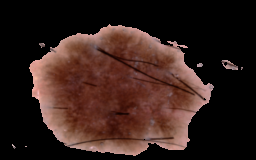

In [ ]:
im = T.ToPILImage()(event['im_teste'][3][0])
im

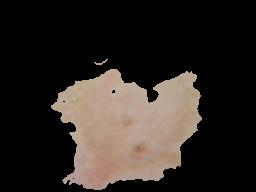

In [ ]:
import base64
from io import BytesIO
from PIL import Image

def base64_to_image(base64_string):
    # Decodificar a string Base64 para bytes
    image_bytes = base64.b64decode(base64_string)

    # Criar um buffer de memória e carregar a imagem com PIL
    image = Image.open(BytesIO(image_bytes))

    return image

# Exemplo de uso com uma string Base64 (substitua pela sua)
base64_string = event["image_data"]

# Converter e exibir a imagem
img = base64_to_image(base64_string)
img  # Exibe a imagem

In [ ]:
for k, v in result_dict.items():
  print(k, ":\n\t")
  print("Diagnóstico:\n\t", v['diagnosis'],'\n', 100*"=",'\n')
  print("Prognóstico:\n\t", v['prognosis'],'\n', 100*"=",'\n')
  print("Relatório:\n\t", v['validation'])

In [ ]:
event['im_teste'][1].squeeze(0).shape

torch.Size([1, 192, 256])

In [ ]:
def convert_to_base64(pil_image):
  """
  Convert PIL images to Base64 encoded strings

  :param pil_image: PIL image
  :return: Base64 string
  """
  pil_image = pil_image.convert("RGB")
  buffered = BytesIO()
  pil_image.save(buffered, format="JPEG")  # You can change the format if needed
  img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
  return img_str

In [ ]:
import base64
from langchain_core.messages import HumanMessage


# # Caminho da imagem
image_path = "/content/Image/train-image/image/ISIC_8966407.jpg"

# # Converter a imagem para Base64
with open(image_path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
# encoded_string="iVBORw0KGgoAAAANSUhEUgAAAG0AAABmCAYAAADBPx+VAAAACXBIWXMAAAsTAAALEwEAmpwYAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAA3VSURBVHgB7Z27r0zdG8fX743i1bi1ikMoFMQloXRpKFFIqI7LH4BEQ+NWIkjQuSWCRIEoULk0gsK1kCBI0IhrQVT7tz/7zZo888yz1r7MnDl7z5xvsjkzs2fP3uu71nNfa7lkAsm7d++Sffv2JbNmzUqcc8m0adOSzZs3Z+/XES4ZckAWJEGWPiCxjsQNLWmQsWjRIpMseaxcuTKpG/7HP27I8P79e7dq1ars/yL4/v27S0ejqwv+cUOGEGGpKHR37tzJCEpHV9tnT58+dXXCJDdECBE2Ojrqjh071hpNECjx4cMHVycM1Uhbv359B2F79+51586daxN/+pyRkRFXKyRDAqxEp4yMlDDzXG1NPnnyJKkThoK0VFd1ELZu3TrzXKxKfW7dMBQ6bcuWLW2v0VlHjx41z717927ba22U9APcw7Nnz1oGEPeL3m3p2mTAYYnFmMOMXybPPXv2bNIPpFZr1NHn4HMw0KRBjg9NuRw95s8PEcz/6DZELQd/09C9QGq5RsmSRybqkwHGjh07OsJSsYYm3ijPpyHzoiacg35MLdDSIS/O1yM778jOTwYUkKNHWUzUWaOsylE00MyI0fcnOwIdjvtNdW/HZwNLGg+sR1kMepSNJXmIwxBZiG8tDTpEZzKg0GItNsosY8USkxDhD0Rinuiko2gfL/RbiD2LZAjU9zKQJj8RDR0vJBR1/Phx9+PHj9Z7REF4nTZkxzX4LCXHrV271qXkBAPGfP/atWvu/PnzHe4C97F48eIsRLZ9+3a3f/9+87dwP1JxaF7/3r17ba+5l4EcaVo0lj3SBq5kGTJSQmLWMjgYNei2GPT1MuMqGTDEFHzeQSP2wi/jGnkmPJ/nhccs44jvDAxpVcxnq0F6eT8h4ni/iIWpR5lPyA6ETkNXoSukvpJAD3AsXLiwpZs49+fPn5ke4j10TqYvegSfn0OnafC+Tv9ooA/JPkgQysqQNBzagXY55nO/oa1F7qvIPWkRL12WRpMWUvpVDYmxAPehxWSe8ZEXL20sadYIozfmNch4QJPAfeJgW3rNsnzphBKNJM2KKODo1rVOMRYik5ETy3ix4qWNI81qAAirizgMIc+yhTytx0JWZuNI03qsrgWlGtwjoS9XwgUhWGyhUaRZZQNNIEwCiXD16tXcAHUs79co0vSD8rrJCIW98pzvxpAWyyo3HYwqS0+H0BjStClcZJT5coMm6D2LOF8TolGJtK9fvyZpyiC5ePFi9nc/oJU4eiEP0jVoAnHa9wyJycITMP78+eMeP37sXrx44d6+fdt6f82aNdkx1pg9e3Zb5W+RSRE+n+VjksQWifvVaTKFhn5O8my63K8Qabdv33b379/PiAP//vuvW7BggZszZ072/+TJk91YgkafPn166zXB1rQHFvouAWHq9z3SEevSUerqCn2/dDCeta2jxYbr69evk4MHDyY7d+7MjhMnTiTPnz9Pfv/+nfQT2ggpO2dMF8cghuoM7Ygj5iWCqRlGFml0QC/ftGmTmzt3rmsaKDsgBSPh0/8yPeLLBihLkOKJc0jp8H8vUzcxIA1k6QJ/c78tWEyj5P3o4u9+jywNPdJi5rAH9x0KHcl4Hg570eQp3+vHXGyrmEeigzQsQsjavXt38ujRo44LQuDDhw+TW7duRS1HGgMxhNXHgflaNTOsHyKvHK5Ijo2jbFjJBQK9YwFd6RVMzfgRBmEfP37suBBm/p49e1qjEP2mwTViNRo0VJWH1deMXcNK08uUjVUu7s/zRaL+oLNxz1bpANco4npUgX4G2eFbpDFyQoQxojBCpEGSytmOH8qrH5Q9vuzD6ofQylkCUmh8DBAr+q8JCyVNtWQIidKQE9wNtLSQnS4jDSsxNHogzFuQBw4cyM61UKVsjfr3ooBkPSqqQHesUPWVtzi9/vQi1T+rJj7WiTz4Pt/l3LxUkr5P2VYZaZ4URpsE+st/dujQoaBBYokbrz/8TJNQYLSonrPS9kUaSkPeZyj1AWSj+d+VBoy1pIWVNed8P0Ll/ee5HdGRhrHhR5GGN0r4LGZBaj8oFDJitBTJzIZgFcmU0Y8ytWMZMzJOaXUSrUs5RxKnrxmbb5YXO9VGUhtpXldhEUogFr3IzIsvlpmdosVcGVGXFWp2oU9kLFL3dEkSz6NHEY1sjSRdIuDFWEhd8KxFqsRi1uM/nz9/zpxnwlESONdg6dKlbsaMGS4EHFHtjFIDHwKOo46l4TxSuxgDzi+rE2jg+BaFruOX4HXa0Nnf1lwAPufZeF8/r6zD97WK2qFnGjBxTw5qNGPxT+5T/r7/7RawFC3j4vTp09koCxkeHjqbHJqArmH5UrFKKksnxrK7FuRIs8STfBZv+luugXZ2pR/pP9Ois4z+TiMzUUkUjD0iEi1fzX8GmXyuxUBRcaUfykV0YZnlJGKQpOiGB76x5GeWkWWJc3mOrK6S7xdND+W5N6XyaRgtWJFe13GkaZnKOsYqGdOVVVbGupsyA/l7emTLHi7vwTdirNEt0qxnzAvBFcnQF16xh/TMpUuXHDowhlA9vQVraQhkudRdzOnK+04ZSP3DUhVSP61YsaLtd/ks7ZgtPcXqPqEafHkdqa84X6aCeL7YWlv6edGFHb+ZFICPlljHhg0bKuk0CSvVznWsotRu433alNdFrqG45ejoaPCaUkWERpLXjzFL2Rpllp7PJU2a/v7Ab8N05/9t27Z16KUqoFGsxnI9EosS2niSYg9SpU6B4JgTrvVW1flt1sT+0ADIJU2maXzcUTraGCRaL1Wp9rUMk16PMom8QhruxzvZIegJjFU7LLCePfS8uaQdPny4jTTL0dbee5mYokQsXTIWNY46kuMbnt8Kmec+LGWtOVIl9cT1rCB0V8WqkjAsRwta93TbwNYoGKsUSChN44lgBNCoHLHzquYKrU6qZ8lolCIN0Rh6cP0Q3U6I6IXILYOQI513hJaSKAorFpuHXJNfVlpRtmYBk1Su1obZr5dnKAO+L10Hrj3WZW+E3qh6IszE37F6EB+68mGpvKm4eb9bFrlzrok7fvr0Kfv727dvWRmdVTJHw0qiiCUSZ6wCK+7XL/AcsgNyL74DQQ730sv78Su7+t/A36MdY0sW5o40ahslXr58aZ5HtZB8GH64m9EmMZ7FpYw4T6QnrZfgenrhFxaSiSGXtPnz57e9TkNZLvTjeqhr734CNtrK41L40sUQckmj1lGKQ0rC37x544r8eNXRpnVE3ZZY7zXo8NomiO0ZUCj2uHz58rbXoZ6gc0uA+F6ZeKS/jhRDUq8MKrTho9fEkihMmhxtBI1DxKFY9XLpVcSkfoi8JGnToZO5sU5aiDQIW716ddt7ZLYtMQlhECdBGXZZMWldY5BHm5xgAroWj4C0hbYkSc/jBmggIrXJWlZM6pSETsEPGqZOndr2uuuR5rF169a2HoHPdurUKZM4CO1WTPqaDaAd+GFGKdIQkxAn9RuEWcTRyN2KSUgiSgF5aWzPTeA/lN5rZubMmR2bE4SIC4nJoltgAV/dVefZm72AtctUCJU2CMJ327hxY9t7EHbkyJFseq+EJSY16RPo3Dkq1kkr7+q0bNmyDuLQcZBEPYmHVdOBiJyIlrRDq41YPWfXOxUysi5fvtyaj+2BpcnsUV/oSoEMOk2CQGlr4ckhBwaetBhjCwH0ZHtJROPJkyc7UjcYLDjmrH7ADTEBXFfOYmB0k9oYBOjJ8b4aOYSe7QkKcYhFlq3QYLQhSidNmtS2RATwy8YOM3EQJsUjKiaWZ+vZToUQgzhkHXudb/PW5YMHD9yZM2faPsMwoc7RciYJXbGuBqJ1UIGKKLv915jsvgtJxCZDubdXr165mzdvtr1Hz5LONA8jrUwKPqsmVesKa49S3Q4WxmRPUEYdTjgiUcfUwLx589ySJUva3oMkP6IYddq6HMS4o55xBJBUeRjzfa4Zdeg56QZ43LhxoyPo7Lf1kNt7oO8wWAbNwaYjIv5lhyS7kRf96dvm5Jah8vfvX3flyhX35cuX6HfzFHOToS1H4BenCaHvO8pr8iDuwoUL7tevX+b5ZdbBair0xkFIlFDlW4ZknEClsp/TzXyAKVOmmHWFVSbDNw1l1+4f90U6IY/q4V27dpnE9bJ+v87QEydjqx/UamVVPRG+mwkNTYN+9tjkwzEx+atCm/X9WvWtDtAb68Wy9LXa1UmvCDDIpPkyOQ5ZwSzJ4jMrvFcr0rSjOUh+GcT4LSg5ugkW1Io0/SCDQBojh0hPlaJdah+tkVYrnTZowP8iq1F1TgMBBauufyB33x1v+NWFYmT5KmppgHC+NkAgbmRkpD3yn9QIseXymoTQFGQmIOKTxiZIWpvAatenVqRVXf2nTrAWMsPnKrMZHz6bJq5jvce6QK8J1cQNgKxlJapMPdZSR64/UivS9NztpkVEdKcrs5alhhWP9NeqlfWopzhZScI6QxseegZRGeg5a8C3Re1Mfl1ScP36ddcUaMuv24iOJtz7sbUjTS4qBvKmstYJoUauiuD3k5qhyr7QdUHMeCgLa1Ear9NquemdXgmum4fvJ6w1lqsuDhNrg1qSpleJK7K3TF0Q2jSd94uSZ60kK1e3qyVpQK6PVWXp2/FC3mp6jBhKKOiY2h3gtUV64TWM6wDETRPLDfSakXmH3w8g9Jlug8ZtTt4kVF0kLUYYmCCtD/DrQ5YhMGbA9L3ucdjh0y8kOHW5gU/VEEmJTcL4Pz/f7mgoAbYkAAAAAElFTkSuQmCC"
# encoded_string=image_path

# msg = [{"role": "user",
#         # "content": "Descreva a imagem",
#         "content": "What is in this picture?",
#         # "content": "Descreva a imagem com base no checklist de 7 pontos para detecção de cancer de pele .",
#         "image": [encoded_string]
#         }]
# encoded_string = event['image_data']
# encoded_string = convert_to_base64(T.ToPILImage()(event['im_teste'][3][0]))
content_str = """
Chat, você conhece o algoritmo ABCD para identificação de melanoma maligno? Poderia descreve-lo para mim com base na imagem que estou te entregando?
"""
content = [
    {'type': 'image_url', 'image_url': f'data:image/jpeg;base64,{encoded_string}'},
    {'type': 'text', 'text': content_str}
]
msg = [HumanMessage(content=content)]
response = llm.invoke(msg)
print(response.content)

In [ ]:
!cp /content/Image/train-image/image/ISIC_9972649.jpg /content/ISIC_9972649.jpg

In [ ]:
dt_ref[dt_ref['target'] == 1]['isic_id']

,isic_id
387,ISIC_0082829
935,ISIC_0096034
1245,ISIC_0104229
1846,ISIC_0119495
3478,ISIC_0157834
...,...
396165,ISIC_9877311
398671,ISIC_9941636
399936,ISIC_9972649
399943,ISIC_9972877


In [ ]:
print(f"""
        Duas imagens foram fornecidas para análise:
          1️⃣ Imagem original da lesão de pele, que mantém seu contexto visual completo.
          2️⃣ Imagem segmentada, que realça os contornos e características internas da lesão.

        Por favor, observe as características da mancha ou pinta nas imagens fornecidas e retorne uma resposta no
        seguinte formato JSON, baseado nas observações visuais:
        Adicionalmente, o maior diâmetro da lesão é de {4.18} mm.
        {{
          "Pontos": {{
            "Assimetria": "Sim ou Não. Motivo",
            "Bordas Irregulares": "Sim ou Não. Motivo",
            "Cor Desigual": "Sim ou Não. Motivo",
            "Diâmetro Maior que 6 mm": "Sim ou Não. Motivo",

            "Sangramento ou Secreção": "Sim ou Não. Motivo"
          }},
          "Resposta Final": "Quantidade de 'Sim' nos pontos"
        }}
        Cada campo deve conter 'Sim' ou 'Não', seguido de uma explicação breve do motivo da observação (por exemplo, 'Sim, a mancha é assimétrica', ou 'Não, as bordas são regulares'). A resposta final será a contagem do número de 'Sim' nos pontos observados.
      """)


        Duas imagens foram fornecidas para análise:
          1️⃣ Imagem original da lesão de pele, que mantém seu contexto visual completo.
          2️⃣ Imagem segmentada, que realça os contornos e características internas da lesão.

        Por favor, observe as características da mancha ou pinta nas imagens fornecidas e retorne uma resposta no 
        seguinte formato JSON, baseado nas observações visuais:
        Adicionalmente, o maior diâmetro da lesão é de 4.18 mm.
        {
          "Pontos": {
            "Assimetria": "Sim ou Não. Motivo",
            "Bordas Irregulares": "Sim ou Não. Motivo",
            "Cor Desigual": "Sim ou Não. Motivo",
            "Diâmetro Maior que 6 mm": "Sim ou Não. Motivo",

            "Sangramento ou Secreção": "Sim ou Não. Motivo"
          },
          "Resposta Final": "Quantidade de 'Sim' nos pontos"
        }
        Cada campo deve conter 'Sim' ou 'Não', seguido de uma explicação breve do motivo da observação (por exemplo, 'Sim, a man